# UC Berkeley Milling Dataset
> Reproduces the results from the UC Berkeley Milling Dataset.

Here, we will reproduce the results, figures, and tables from the experiment using the UC Berekely Milling Dataset. You can find dataset on the [NASA Prognostics Repository](https://www.nasa.gov/content/prognostics-center-of-excellence-data-set-repository).

A detailed description of the dataset is found in the [PyPHM example notebook](https://github.com/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb) (which you can also [run on Google Colab](https://colab.research.google.com/github/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb)).

The first step to reproduce the results is to get the proper environment setup and download the data.

## Table of Contents
* [1. Setup Notebook](#setup-notebook) - clone the repo and import require packages
* [2. Explore Data](#explore-data) - brief exploration of the data
* [3. Prep Data](#3.-Prep-Data) - prepare the data by segmenting the signals into windows
* [4. Feature Engineering](#4.-Feature-Engineering) - extract features from the segmented signals
* [5. Model Training](#4.-Train-Models-with-a-Random-Search) - train the models in a random search
* [6. Filter Results](#6.-Filter-Results) - filter the results to find the best models
* [7. Visualize Results](#5.-Summarize-Results) - inspect the results of the random search


# 1. Setup Notebook <a name="setup-notebook"></a>
**For Google Colab:**
To run the notebook on google colab you must clone the repo an download the data using PyPHM. This can be done by running the following cell.

In [ ]:
# ONLY RUN IF YOU'RE USING GOOGLE COLAB
!git clone https://github.com/tvhahn/tspipe

# move into project folder
%cd tspipe

!pip install tsfresh pyphm
!pip install -e .

from IPython.display import clear_output
clear_output()

**Import Packages:**
Don't skip this step! Needed for Google Colab and if run locally.

In [29]:
from pyphm.datasets.milling import MillingPrepMethodA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import scipy.io as sio # for reading matlab files
import zipfile
import gdown
import os
import glob

import warnings
warnings.filterwarnings("ignore") # supress all the matplotlib deprecation warnings
from IPython.display import clear_output, display, Image # incase you want to clear the output of a cell
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set the project (root folder) and the data folder locations
path_colab = Path.cwd().parent.parent / 'content'

if path_colab.exists():
    proj_dir = Path.cwd() # get projet folder of repository - use if on colab
else:
    proj_dir = Path.cwd().parent # on local machine in ./notebooks folder

print(proj_dir) 

/home/tim/Documents/feat-store


**Download the milling dataset:** We will use the [download_data.py](https://github.com/tvhahn/tspipe/blob/master/src/dataprep/download_data.py) script in the `src.dataprep` module to download the data.

In [3]:
!python {proj_dir}/src/dataprep/download_data.py -p {proj_dir}

2022-11-03 13:38:14,379 - __main__ - INFO - Download the datasets


# 2. Explore Data <a name="explore-data"></a>
We can now explore the milling dataset. For a full breakdown of the dataset, see the [example notebook in PyPHM](https://github.com/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb) (Colab notebook [here](https://colab.research.google.com/github/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb)).

We'll recreate the figure showing the six different signals using the `plot_raw_milling_signals` function from [visualize.py](https://github.com/tvhahn/tspipe/blob/master/src/visualization/visualize.py#L1075).

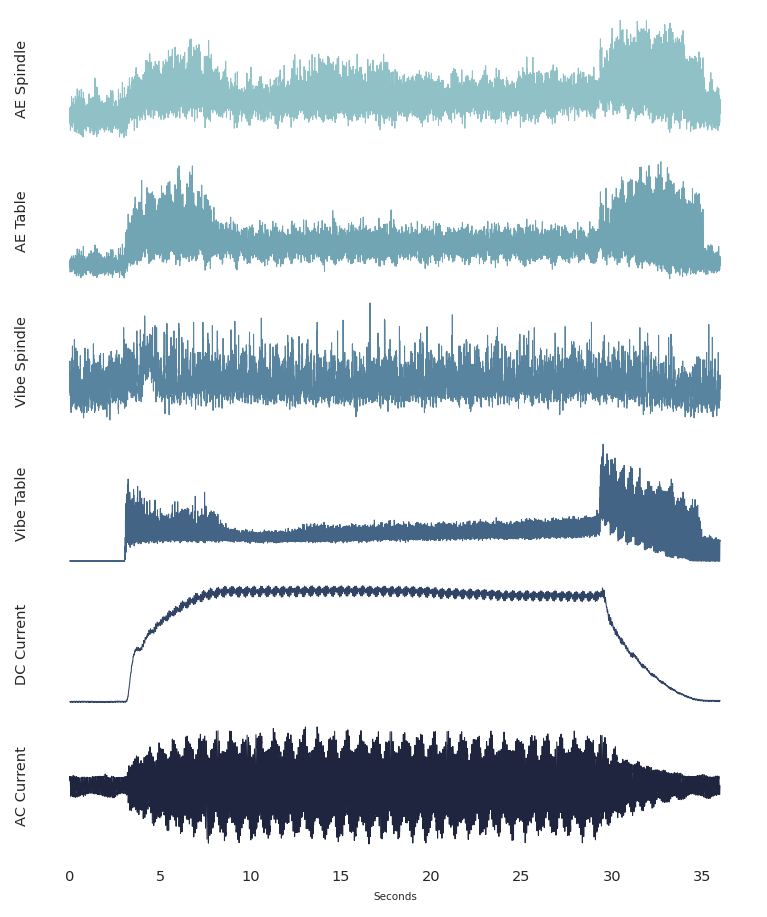

In [4]:
from src.visualization.visualize import plot_raw_milling_signals

raw_data_dir = proj_dir / 'data' / 'raw'

# use PyPHM to load the data
mill = MillingPrepMethodA(root=raw_data_dir, download=False)
data = mill.load_mat()

plot_raw_milling_signals(
    data,
    cut_no=145, # change the cut number to see different cuts
    save_plot=False,
)

# 3. Prep Data
Next, we will break each signal from the dataset into windows. In the paper, we used a window of 1024 and a stride of 64. However, if you are running this on Google Colab, we **need to use a smaller window length to avoid running out of memory**. We will use a window length of 64 and a stride of 64 for this case as a demonstration.

The below script, from [make_dataset_milling.py](https://github.com/tvhahn/tspipe/blob/master/src/dataprep/make_dataset_milling.py), creates the individual windows and saves them as a CSV file in the `data/raw/milling` directory.

In [6]:
# change the window length and stride
WINDOW_LEN = 64
STRIDE = 64
RAW_DIR_NAME = f'stride{STRIDE}_len{WINDOW_LEN}'

In [6]:
# run the script
!python {proj_dir}/src/dataprep/make_dataset_milling.py \
	-p {proj_dir} \
	--path_data_dir {proj_dir}/data/ \
	--window_len {WINDOW_LEN} \
	--stride {STRIDE} \
	--raw_dir_name {RAW_DIR_NAME}

2022-11-01 08:58:18,299 - __main__ - INFO - Creating windows of the milling dataset
path_data_dir: /home/tim/Documents/feat-store/data
Shape of final df: (740480, 11)
Saving dataframe as milling.csv.gz ...


In [7]:
# load the milling.csv.gz file with pandas
df = pd.read_csv(proj_dir / 'data' / 'raw' / 'milling' / RAW_DIR_NAME / 'milling.csv.gz')
df.head()

,cut_id,cut_no,case,time,ae_spindle,ae_table,vib_spindle,vib_table,smcdc,smcac,tool_class
0,0_0,0,1,0.000,0.219727,0.272827,0.733643,2.116699,6.840820,0.124512,0
1,0_0,0,1,0.004,0.246582,0.322266,0.778809,2.277832,6.660156,-0.561523,0
2,0_0,0,1,0.008,0.294189,0.283813,0.758057,2.343750,6.508789,-2.099609,0
3,0_0,0,1,0.012,0.323486,0.260010,0.726318,2.448730,6.542969,-2.731934,0
4,0_0,0,1,0.016,0.290527,0.253296,0.653076,2.546387,6.621094,-3.505859,0


The dataframe, above, can now be used with the [tsfresh](https://github.com/blue-yonder/tsfresh) feature engineering package. We'll use that next.

# 4. Feature Engineering
The features are created using tsfresh. The features are created from a pandas dataframe using a dictionary of feature extraction functions.

In the original paper, we used the `comprehensive_features` dictionary from the [feat_param_dict.py](https://github.com/tvhahn/tspipe/blob/master/src/features/feat_param_dict.py). However, using the comprehensive features takes a long time to compute and will likely crash the Google Colab. For this notebook, we will use a smaller set of features, called `dummy`, which is also defined in the [feat_param_dict.py](https://github.com/tvhahn/tspipe/blob/master/src/features/feat_param_dict.py) file.

We will use the [build_features.py](https://github.com/tvhahn/tspipe/blob/master/src/features/build_features.py) script to create the features. Below are the variables used when calling the script:

In [7]:
# change these variables for the script
DATASET = 'milling' # either 'milling' or 'cnc'
PROCESSED_DIR_NAME = 'milling_features' # name of folder to save features in
FEAT_FILE_NAME = 'milling_features.csv' # name of file to save features in
RAW_DIR_NAME = f'stride{STRIDE}_len{WINDOW_LEN}' # name of folder containing raw data
RAW_FILE_NAME = 'milling.csv.gz' # name of file containing raw data
FEAT_DICT_NAME = 'dummy' # as defined in build_features.py. Either 'dummy' or 'comp'
N_CORES = 4 # number of cores to use for multiprocessing

In [9]:
# run the script
!python {proj_dir}/src/features/build_features.py \
	-p {proj_dir} \
	--dataset {DATASET} \
	--path_data_dir {proj_dir}/data/ \
	--raw_dir_name {RAW_DIR_NAME} \
	--raw_file_name {RAW_FILE_NAME} \
	--processed_dir_name {PROCESSED_DIR_NAME} \
	--feat_file_name {FEAT_FILE_NAME} \
	--feat_dict_name {FEAT_DICT_NAME} \
	--n_cores {N_CORES}

2022-10-26 09:50:07,672 - __main__ - INFO - making final features set from raw data
df.columns Index(['cut_id', 'cut_no', 'case', 'time', 'ae_spindle', 'ae_table',
       'vib_spindle', 'vib_table', 'smcdc', 'smcac', 'tool_class'],
      dtype='object')
Shape of df: (740480, 11)
2022-10-26 09:50:08,539 - __main__ - INFO - extracting features from raw milling dataframe
Feature Extraction: 100%|███████████████████████| 20/20 [00:08<00:00,  2.34it/s]


Again, we can look at the features we just created.

In [8]:
# load the milling.csv.gz file with pandas
df_feat = pd.read_csv(proj_dir / 'data' / 'processed' / 'milling' / PROCESSED_DIR_NAME / FEAT_FILE_NAME)
df_feat.head()

,cut_id,ae_spindle__length,ae_spindle__kurtosis,ae_table__length,ae_table__kurtosis,vib_spindle__length,vib_spindle__kurtosis,vib_table__length,vib_table__kurtosis,smcdc__length,smcdc__kurtosis,smcac__length,smcac__kurtosis,cut_no,case,tool_class
0,0_0,64.0,-0.348446,64.0,-0.190215,64.0,-0.126833,64.0,2.144662,64.0,-0.256599,64.0,-1.367461,0,1,0
1,0_1,64.0,0.724161,64.0,-0.236114,64.0,0.504015,64.0,2.357173,64.0,0.384966,64.0,-1.248971,0,1,0
2,0_10,64.0,0.412827,64.0,0.031749,64.0,0.536186,64.0,2.901181,64.0,-0.167447,64.0,-1.327537,0,1,0
3,0_11,64.0,-0.087264,64.0,-0.376136,64.0,0.511172,64.0,2.578223,64.0,-0.367538,64.0,-1.441127,0,1,0
4,0_12,64.0,1.012060,64.0,1.804934,64.0,-0.108143,64.0,2.400641,64.0,-0.038878,64.0,-1.279095,0,1,0


The actual feature dataset used in the paper is much larger. We can download it from Google Drive and take a look at it.

In [9]:
path_processed_dir = proj_dir / 'data' / 'processed' / 'milling' / 'milling_features_comp_stride64_len1024'
path_processed_dir.mkdir(parents=True, exist_ok=True)

In [13]:
# download the file from google drive if it hasn't been yet
zip_file_name = 'milling_features_comp_stride64_len1024.zip'

gdown.download(
    id='1I0OjXVSkBBxhw3w8KtWbITRR0yAeKk8j', 
    output=str(path_processed_dir / zip_file_name), 
    quiet=False
    )

# extract the zip file
print("Extracting...")
with zipfile.ZipFile(path_processed_dir / zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(path_processed_dir)

Downloading...
From: https://drive.google.com/uc?id=1I0OjXVSkBBxhw3w8KtWbITRR0yAeKk8j
To: /home/tim/Documents/feat-store/data/processed/milling/milling_features_comp_stride64_len1024/milling_features_comp_stride64_len1024.zip
100%|██████████| 321M/321M [00:04<00:00, 65.6MB/s] 


In [10]:
# load the milling_features_comp_stride64_len1024.csv in pandas
df_feat = pd.read_csv(path_processed_dir / 'milling_features_comp_stride64_len1024.csv')
df_feat.head()

,cut_id,smcac__time_reversal_asymmetry_statistic__lag_1,smcac__time_reversal_asymmetry_statistic__lag_2,smcac__time_reversal_asymmetry_statistic__lag_3,smcac__c3__lag_1,smcac__c3__lag_2,smcac__c3__lag_3,smcac__cid_ce__normalize_True,smcac__cid_ce__normalize_False,smcac__symmetry_looking__r_0.0,...,smcdc__query_similarity_count__query_None__threshold_0.0,"smcdc__matrix_profile__feature_""min""__threshold_0.98","smcdc__matrix_profile__feature_""max""__threshold_0.98","smcdc__matrix_profile__feature_""mean""__threshold_0.98","smcdc__matrix_profile__feature_""median""__threshold_0.98","smcdc__matrix_profile__feature_""25""__threshold_0.98","smcdc__matrix_profile__feature_""75""__threshold_0.98",cut_no,case,tool_class
0,87_20,-0.009862,-0.008820,0.002745,-0.997182,-0.733741,-0.354140,11.424614,17.725740,0.0,...,NaN,3.789384,5.941307,4.691854,4.617381,3.912163,5.372661,87,11,1
1,87_21,-0.014233,-0.006940,0.003651,-1.006841,-0.739986,-0.355168,11.403917,17.642734,0.0,...,NaN,3.022031,5.579988,3.749164,3.582706,3.339192,4.022824,87,11,1
2,87_22,-0.023152,-0.024342,-0.000312,-1.067194,-0.764072,-0.354402,11.388923,17.604872,0.0,...,NaN,2.896524,5.421811,3.517452,3.349038,3.180649,3.620394,87,11,1
3,87_23,-0.008329,-0.001119,0.017044,-1.070455,-0.782522,-0.374350,11.327472,17.496560,0.0,...,NaN,2.866619,5.212993,3.357202,3.245255,3.119372,3.488481,87,11,1
4,87_24,0.006926,0.018749,0.019649,-1.014428,-0.744961,-0.359926,11.280507,17.361086,0.0,...,NaN,2.866619,4.435201,3.249217,3.202348,3.032700,3.403513,87,11,1


Let's get some statistics on the feature dataset.

In [11]:
# get the percentage of each tool_class
df_p = df_feat.groupby("tool_class").size() / df_feat.shape[0] * 100
df_p = df_p.reset_index()
df_p.columns = ["tool_class", "percentage"]

# get the count of each tool_class
df_c = df_feat.groupby("tool_class").size().to_frame().reset_index()
df_c.columns = ["tool_class", "count"]

# merge the two dataframes
df_pc = df_p.merge(df_c, on="tool_class")[["tool_class", "count", "percentage"]]
df_pc["percentage"] = df_pc["percentage"].round(2)
df_pc

,tool_class,count,percentage
0,0,3311,36.63
1,1,5065,56.03
2,2,664,7.35


# 5. Model Training
A random search is used to find the best model and hyperparameters. The random search is implemented in the [train.py](https://github.com/tvhahn/tspipe/blob/master/src/models/train.py) script. The parameters to search over are initialized in the [random_search_setup.py](https://github.com/tvhahn/tspipe/blob/master/src/models/random_search_setup.py) -- when you clone the repo to your local computer you can modify it there.

In [12]:
DATASET = 'milling' # either 'milling' or 'cnc'
SAVE_DIR_NAME = 'interim_results_milling' # name of folder to results in
PROCESSED_DIR_NAME = 'milling_features_comp_stride64_len1024' # name of folder where features are saved
RAND_SEARCH_ITER = 2 # number of iterations for random search
FEAT_FILE_NAME = 'milling_features_comp_stride64_len1024.csv' # name of the original feature file
SAMPLE_SEED = 20 # OPTIONAL seed to fix the search space

In [25]:
# remove the sample_seed if you want a different sample
!python {proj_dir}/src/models/train.py \
    -p {proj_dir} \
    --dataset {DATASET} \
    --save_dir_name {SAVE_DIR_NAME} \
    --processed_dir_name {PROCESSED_DIR_NAME} \
    --rand_search_iter {RAND_SEARCH_ITER} \
    --feat_file_name {FEAT_FILE_NAME} \
    --sample_seed {SAMPLE_SEED}

Assume on local compute
k_folds: 7
classifier: knn, oversamp_method: svm_smote, oversamp_ratio: 0.95 undersamp_method: random_under_bootstrap undersamp_ratio: 0.4

 {'KNeighborsClassifier_metric': 'manhattan', 'KNeighborsClassifier_n_neighbors': 11, 'KNeighborsClassifier_weights': 'uniform'}
feat_select_method:  random
k_folds in kfold_cv:  7
0
####### Exception #######
The specified ratio required to generate new sample in the majority class while trying to remove samples. Please increase the ratio.
classifier: rf, oversamp_method: smote, oversamp_ratio: 1.0 undersamp_method: random_under_bootstrap undersamp_ratio: 0.6

 {'RandomForestClassifier_bootstrap': True, 'RandomForestClassifier_class_weight': None, 'RandomForestClassifier_criterion': 'gini', 'RandomForestClassifier_max_depth': 443, 'RandomForestClassifier_min_samples_leaf': 35, 'RandomForestClassifier_min_samples_split': 91, 'RandomForestClassifier_n_estimators': 305}
feat_select_method:  random
k_folds in kfold_cv:  7
0
####

The random search creates a csv file with the results of the search. In our case, the results are stored in the `interim_results_milling` folder under the name `results_{SAMPLE_SEED}.csv`.

Let's look at the results file.

In [13]:
path_interim_results_dir = proj_dir / 'models' / SAVE_DIR_NAME

# use path to find all the files in the path_interim_results_dir
# and get the latest one
list_of_files = glob.glob(str(path_interim_results_dir / '*.csv'))
latest_file = max(list_of_files, key=os.path.getctime)

print("Most recent results file: ", latest_file)

Most recent results file:  /home/tim/Documents/feat-store/models/interim_results_milling/results_20.csv


In [14]:
df_results = pd.read_csv(Path(latest_file))
df_results.head()

,undersamp_ratio,undersamp_method,scaler_method,oversamp_ratio,oversamp_method,max_feats,feat_select_method,feat_col_list,early_stopping_rounds,dataprep_method,...,n_thresholds_max,test_strat_group_worst_prauc,tn_fp_fn_tp_worst_prauc,RandomForestClassifier_bootstrap,RandomForestClassifier_class_weight,RandomForestClassifier_criterion,RandomForestClassifier_max_depth,RandomForestClassifier_min_samples_leaf,RandomForestClassifier_min_samples_split,RandomForestClassifier_n_estimators
0,NaN,NaN,minmax,0.3,smote_tomek,10,random,"['ae_spindle__fft_coefficient__attr_""abs""__coe...",NaN,milling_standard,...,3202,"[1, 9, 5, 10]","(1928, 217, 9, 141)",True,NaN,entropy,224,29,92,395
1,NaN,NaN,minmax,0.3,smote_tomek,10,random,"['ae_spindle__fft_coefficient__attr_""abs""__coe...",NaN,milling_standard,...,3202,"[1, 9, 5, 10]","(1928, 217, 9, 141)",True,NaN,entropy,224,29,92,395


# 6. Filter Results
The above results are illustrative of what the random search will do. However, if you train thousands of models, you will want to filter the results to find the best models. Many of the models will also be junk.

There may also be multiple "results" csv files in the interim results folder. We can combine these into one using the [compile.py](https://github.com/tvhahn/tspipe/blob/master/src/models/compile.py) script. For now, we will download the compiled results file from Google Drive and filter it.

In [15]:
path_final_results_dir = proj_dir / 'models' / 'final_results_milling'
path_final_results_dir.mkdir(parents=True, exist_ok=True)

In [16]:
zip_file_name = 'compiled_results_milling_2022_08_25_final.zip'

# download the file from google drive if it hasn't been yet
gdown.download(
    id='1zpNLw2wsX4RCMGmY7Wl0aEidDCiAJJ-P', 
    output=str(path_final_results_dir / zip_file_name), 
    quiet=False
    )

# extract the zip file
print("Extracting...")
with zipfile.ZipFile(path_final_results_dir / zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(path_final_results_dir)

Downloading...
From: https://drive.google.com/uc?id=1zpNLw2wsX4RCMGmY7Wl0aEidDCiAJJ-P
To: /home/tim/Documents/feat-store/models/final_results_milling/compiled_results_milling_2022_08_25_final.zip
100%|██████████| 25.8M/25.8M [00:00<00:00, 53.9MB/s]


Extracting...


Let's open up the `compiled_results.csv` file, which we just extracted, and take a look at it.

In [19]:
df_results = pd.read_csv(path_final_results_dir / 'compiled_results.csv')

print("Number of results: ", df_results.shape[0])
df_results.head()

Number of results:  73274


,classifier,sampler_seed,date_time,dataset,dataprep_method,feat_file_name,id,meta_label_cols,feat_select_method,max_feats,...,KNeighborsClassifier_weights,XGB_alpha,XGB_eta,XGB_eval_metric,XGB_lambda,XGB_max_depth,XGB_objective,XGB_scale_pos_weight,XGB_seed,SVC_degree
0,ridge,30402896,2022-09-14-1244-20,milling,milling_standard,milling_features_comp_stride64_len1024.csv,30402896_ridge_2022-09-14-1244-20_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lr,8625985,2022-09-14-1252-42,milling,milling_standard,milling_features_comp_stride64_len1024.csv,8625985_lr_2022-09-14-1252-42_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sgd,30813941,2022-09-14-1254-45,milling,milling_standard,milling_features_comp_stride64_len1024.csv,30813941_sgd_2022-09-14-1254-45_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sgd,7195055,2022-09-14-1301-57,milling,milling_standard,milling_features_comp_stride64_len1024.csv,7195055_sgd_2022-09-14-1301-57_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,lr,19164765,2022-09-14-1304-12,milling,milling_standard,milling_features_comp_stride64_len1024.csv,19164765_lr_2022-09-14-1304-12_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Many of the above models are poorly performing. We will use the [filter.py](https://github.com/tvhahn/tspipe/blob/master/src/models/filter.py) script to filter the results.

In [22]:
DATASET = 'milling' # either 'milling' or 'cnc'
PROCESSED_DIR_NAME = 'milling_features_comp_stride64_len1024' # name of folder where features are saved
FEAT_FILE_NAME = 'milling_features_comp_stride64_len1024.csv' # name of the original feature file
FINAL_DIR_NAME = 'final_results_milling' # name of folder where final results are saved
KEEP_TOP_N = 1 # keeq top n results of each model type
SAVE_N_FIGURES = 0 # the number of figures to save
SAVE_MODELS = False # whether to save the models as pickle
CHECK_FEAT_IMPORTANCE = False # whether to check feature importance

In [23]:
!python {proj_dir}/src/models/filter.py \
    -p {proj_dir} \
    --path_data_dir {proj_dir}/data \
    --path_model_dir {proj_dir}/models \
    --dataset {DATASET} \
    --processed_dir_name {PROCESSED_DIR_NAME} \
    --feat_file_name {FEAT_FILE_NAME} \
    --final_dir_name {FINAL_DIR_NAME} \
    --keep_top_n {KEEP_TOP_N} \
    --save_n_figures {SAVE_N_FIGURES} \
    --save_models {SAVE_MODELS} \
    --check_feat_importance {CHECK_FEAT_IMPORTANCE}

Now we can look at the `compiled_results_filtered.csv` file to see the best models.

In [26]:
df_results = pd.read_csv(path_final_results_dir / 'compiled_results_filtered.csv')
df_results

,classifier,sampler_seed,date_time,dataset,dataprep_method,feat_file_name,id,meta_label_cols,feat_select_method,max_feats,...,KNeighborsClassifier_weights,XGB_alpha,XGB_eta,XGB_eval_metric,XGB_lambda,XGB_max_depth,XGB_objective,XGB_scale_pos_weight,XGB_seed,SVC_degree
0,rf,9569263,2022-09-13-1909-12,milling,milling_standard,milling_features_comp_stride64_len1024.csv,9569263_rf_2022-09-13-1909-12_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xgb,16791440,2022-09-14-2058-12,milling,milling_standard,milling_features_comp_stride64_len1024.csv,16791440_xgb_2022-09-14-2058-12_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,NaN,0.5,0.1,aucpr,3.0,43.0,binary:logistic,67.0,62699.0,NaN
2,knn,8633072,2022-09-13-1847-36,milling,milling_standard,milling_features_comp_stride64_len1024.csv,8633072_knn_2022-09-13-1847-36_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,svm,8601842,2022-09-19-0118-20,milling,milling_standard,milling_features_comp_stride64_len1024.csv,8601842_svm_2022-09-19-0118-20_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sgd,22401228,2022-09-19-0726-55,milling,milling_standard,milling_features_comp_stride64_len1024.csv,22401228_sgd_2022-09-19-0726-55_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,lr,17978280,2022-09-19-0953-21,milling,milling_standard,milling_features_comp_stride64_len1024.csv,17978280_lr_2022-09-19-0953-21_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ridge,200266,2022-09-15-0436-24,milling,milling_standard,milling_features_comp_stride64_len1024.csv,200266_ridge_2022-09-15-0436-24_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,nb,17328988,2022-09-15-0444-45,milling,milling_standard,milling_features_comp_stride64_len1024.csv,17328988_nb_2022-09-15-0444-45_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 7. Visualize Results
Next, we will visualize some of the results. First, we'll start by looking at the precision-recall and ROC curves for the best models.

## Precision-Recall Curves
The `filter.py` script allows you to save the precision-recall and ROC curves for each of the models. This is done by specifying the `save_n_figures` parameter. For each of the models in the `compiled_results_filtered.csv` file, the script will retrain the model (using the same parameters it was originally trained on) and then save the curves. 


We can do this below for each of the top performing models. **Warning:** this will take some time. While training the models will also check the feature importance, using the `check_feat_importance` parameter. If you want, run the cell below to generate these curves, or skip it (all the curves are already in the GitHub repo).

In [27]:
#!#!# WARNING: this cell will take a long time to run #!#!# 

DATASET = 'milling' # either 'milling' or 'cnc'
PROCESSED_DIR_NAME = 'milling_features_comp_stride64_len1024' # name of folder where features are saved
FEAT_FILE_NAME = 'milling_features_comp_stride64_len1024.csv' # name of the original feature file
FINAL_DIR_NAME = 'final_results_milling' # name of folder where final results are saved
KEEP_TOP_N = 1 # keeq top n results of each model type
SAVE_N_FIGURES = 8 # the number of figures to save
SAVE_MODELS = False # whether to save the models as pickle
CHECK_FEAT_IMPORTANCE = True # whether to check feature importance

!python {proj_dir}/src/models/filter.py \
    -p {proj_dir} \
    --path_data_dir {proj_dir}/data \
    --path_model_dir {proj_dir}/models \
    --dataset {DATASET} \
    --processed_dir_name {PROCESSED_DIR_NAME} \
    --feat_file_name {FEAT_FILE_NAME} \
    --final_dir_name {FINAL_DIR_NAME} \
    --keep_top_n {KEEP_TOP_N} \
    --save_n_figures {SAVE_N_FIGURES} \
    --save_models {SAVE_MODELS} \
    --check_feat_importance {CHECK_FEAT_IMPORTANCE}

classifier: rf, oversamp_method: smote_tomek, oversamp_ratio: 0.95 undersamp_method: None undersamp_ratio: None

 {'RandomForestClassifier_n_estimators': 199, 'RandomForestClassifier_min_samples_split': 65, 'RandomForestClassifier_min_samples_leaf': 12, 'RandomForestClassifier_max_depth': 142, 'RandomForestClassifier_criterion': 'entropy', 'RandomForestClassifier_bootstrap': True}
feat_select_method:  random
k_folds in kfold_cv:  7
0
scaling - min/max
using already selected features
x_train shape: (14472, 10)
^C
Traceback (most recent call last):
  File "/home/tim/miniconda3/envs/featstore/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tim/miniconda3/envs/featstore/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decisio

The above curves are saved in the `model_curves` folder. You can look at the curves for each of the eight models.

In [41]:
path_final_results_dir = proj_dir / 'models' / 'final_results_milling_2022_08_25_final' # models from paper
path_model_curves_dir = path_final_results_dir / 'model_curves'

# get the list of all the model cuves in the file folder
file_list = glob.glob(str(path_model_curves_dir / '*.png'))

print("Model curves:")
for file in file_list:
    print(file.split('/')[-1])

Model curves:
curve_17978280_lr_2022-09-19-0953-21_milling.png
curve_200266_ridge_2022-09-15-0436-24_milling.png
curve_8601842_svm_2022-09-19-0118-20_milling.png
curve_22401228_sgd_2022-09-19-0726-55_milling.png
curve_17328988_nb_2022-09-15-0444-45_milling.png
curve_16791440_xgb_2022-09-14-2058-12_milling.png
curve_9569263_rf_2022-09-13-1909-12_milling.png
curve_8633072_knn_2022-09-13-1847-36_milling.png


In [42]:
def display_model_curves(file_list, model_type):
    """
    Display the model curves for a given model type.

    Parameters
    ----------
    file_list : list
        List of all the model curves in the file folder.

    model_type : str
        The model type to display the curve for.

        Options:
            - rf: random forest
            - xgb: xgboost
            - lr: logistic regression
            - svm: support vector machine
            - knn: k-nearest neighbours
            - sgd: stochastic gradient descent linear classifier
            - ridge: ridge regression
            - nb: naive bayes
    """

    # assert that the model type is valid
    assert model_type in ['rf', 'xgb', 'lr', 'svm', 'knn', 'sgd', 'ridge', 'nb'], \
        "Invalid model type. Please choose from: 'rf', 'xgb', 'lr', 'svm', 'knn', 'sgd', 'ridge', 'nb'"

    file_name = [f for f in file_list if model_type in f][0]
    img = mpimg.imread(file_name)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Let's look at the random forest model.

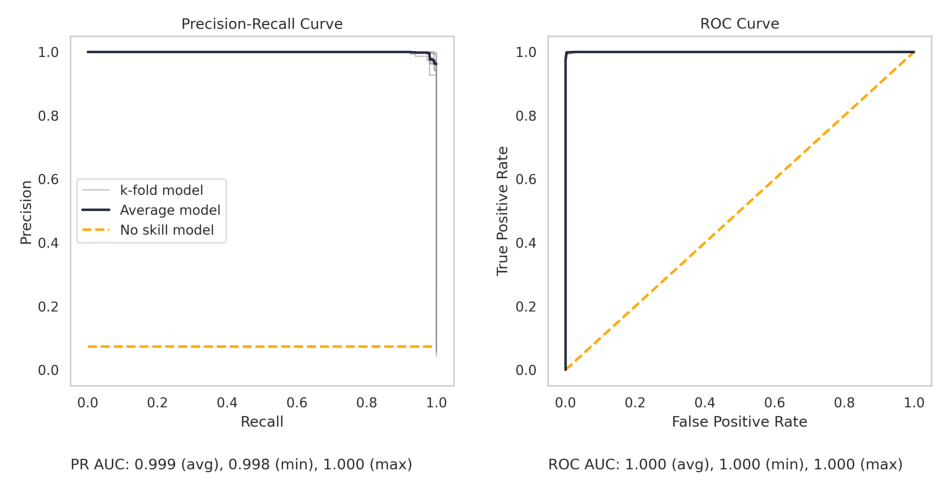

In [43]:
display_model_curves(file_list, model_type="rf")

What about the XGBoost model?

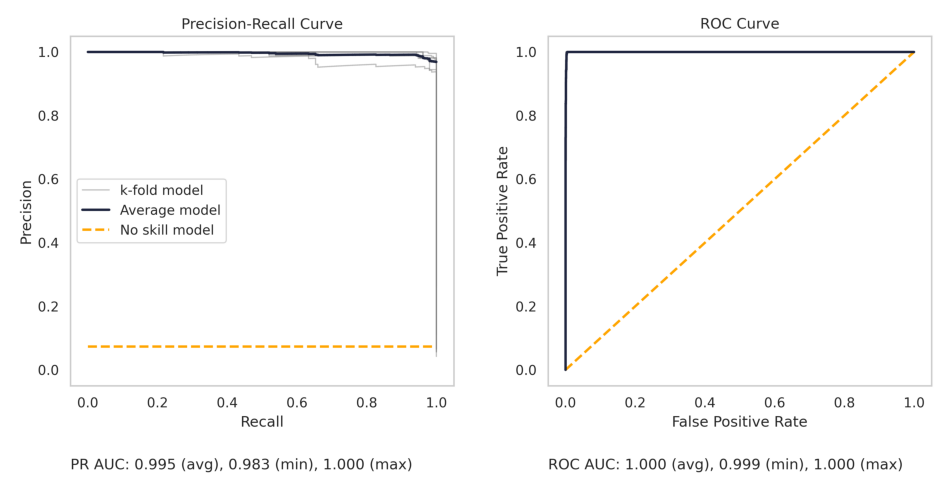

In [39]:
display_model_curves(file_list, model_type="xgb")

You can try out the other models as well. Here's the Naive Bayes model curves (it's not as good).

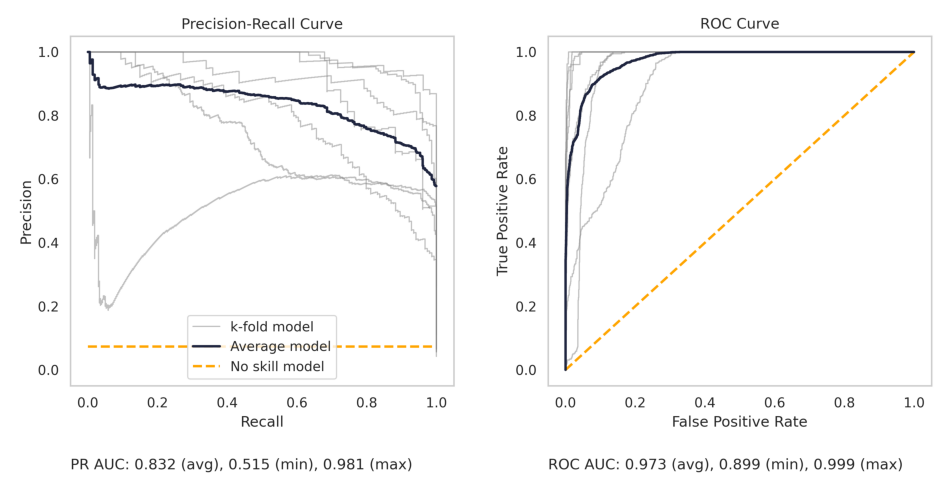

In [40]:
display_model_curves(file_list, model_type="nb")

## Lolipop Chart
The lolipop chart is a way to visualize the relative performance of each model against each other. The `plot_lollipop_results` function is in the [visualize.py](https://github.com/tvhahn/tspipe/blob/master/src/visualization/visualize.py#L280) script and it relies on the `compiled_results_filtered.csv` file.

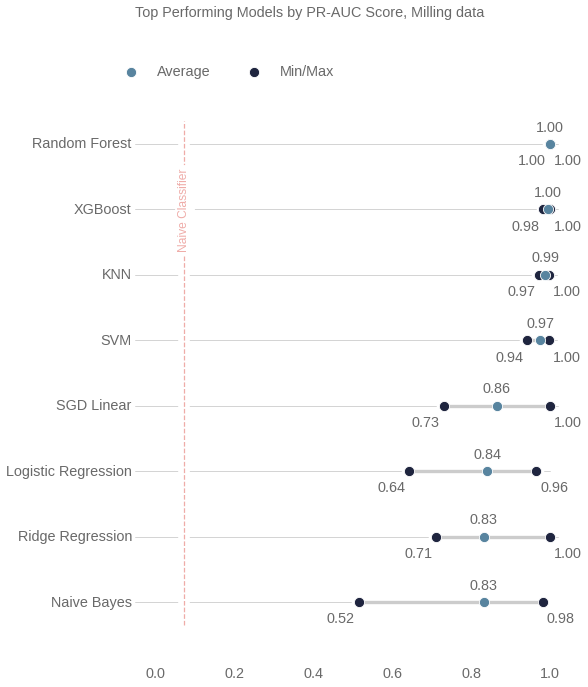

In [52]:
from src.visualization.visualize import plot_lollipop_results

path_final_results_dir = proj_dir / 'models' / 'final_results_milling_2022_08_25_final' # models from paper
df_results = pd.read_csv(path_final_results_dir / 'compiled_results_filtered.csv')


plot_lollipop_results(
    df_results,
    metric="prauc",
    percent_anom=0.0735, # calculated from feature file, in df_pc (see above)
    plt_title="Top Performing Models by PR-AUC Score, Milling data",
    save_plot=False,
    dpi=60,
)